# Rice Leaf Disease Detection using CNN

In [74]:
import numpy as np
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
import os
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [75]:
# Connecting Google Drive with Colab to load data:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
# Changing the path to where Images Dataset is stored:
os.chdir('/content/drive/My Drive/Colab Notebooks/Rice-Leaf-Disease-CNN')


 **Split folders with files (e.g. images) into training, validation and test (dataset) folders.**

- Works on any file types.
- The files get shuffled.
- A seed makes splits reproducible.
- Allows randomized oversampling for imbalanced datasets.
- Optionally group files by prefix.
- (Should) work on all operating systems.

This package is Python only and there are no external dependencies.

To Install, please refer: https://pypi.org/project/split-folders/

In [77]:
pip install split-folders

Since our dataset is balanced (each class has the same number of samples), we will choose `ratio` (If imbalanced dataset, go with parameter `fixed`. Oversampling is turned off by default.)

In [104]:
# Splitting Dataset Images into Train-Test-Split
import splitfolders
splitfolders.ratio("image_data", output="output", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 119 files [00:01, 87.71 files/s]


In [105]:
# Storing the path of Train-Test-Val Images into variables:

train_dir = 'output/train'  # Location of Training images
validation_dir = 'output/val' # Location of Validation images
test_dir ='output/test' # Location of Test images

Data Augmentation:

- Image Data Augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the datase

- Transformations include a range of operations from the field of image manipulation, such as shifts, flips, zooms, and much more.

- Image Data Augmentation is typically only applied to the training dataset, and not to the validation or test dataset. This is different from data preparation such as image resizing and pixel scaling; they must be performed consistently across all datasets that interact with the model.

`ImageDataGenerator()`:

- This Keras deep learning library provides the ability to use Data Augmentation automatically when training a model.

- This is achieved by using the ImageDataGenerator class.

- First, the class may be instantiated and the configuration for the types of Data Augmentation are specified by arguments to the class constructor.

- A range of techniques are supported, as well as pixel scaling methods. We will focus on five main types of Data Augmentation techniques for image data; specifically-

  - Image shifts via the width_shift_range and height_shift_range arguments.
  - Image flips via the horizontal_flip and vertical_flip arguments.
  - Image rotations via the rotation_range argument
  - Image brightness via the brightness_range argument.
  - Image zoom via the zoom_range argument.

In [106]:
# Generating Batches of Image Data with ImageDataGenerator()
# Instantiating the ImageDataGenerator Class for Training Data:

train_datagen = ImageDataGenerator(rescale= (1./255),
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

In [107]:
# Instantiating the ImageDataGenerator Class for Validation Data:

val_datagen = ImageDataGenerator(rescale=(1./255))

In [108]:
# Creating Training Generator with Augmented & Rescaled Images:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=16,
    color_mode='rgb',
    class_mode='categorical')

# Creating Validation Generator with only Rescaled Images:
val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(256,256),
    batch_size=16,
    color_mode='rgb',
    class_mode='categorical')

Found 115 images belonging to 3 classes.
Found 19 images belonging to 3 classes.


In [109]:
# Making a list of the Classes to pass into Plot Titles:
class_names = ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

# Plotting Training images along with their labels:
def plots(ims, figsize=(20,25), rows=4, interp = False, title = None):
    f = plt.figure(figsize=figsize)
    cols = len(ims) // rows if len(ims) % 2 == 0 else len(ims) // rows+1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        sp.set_title(class_names[title[i].tolist().index(1)],fontsize=16)
        plt.imshow(ims[i])


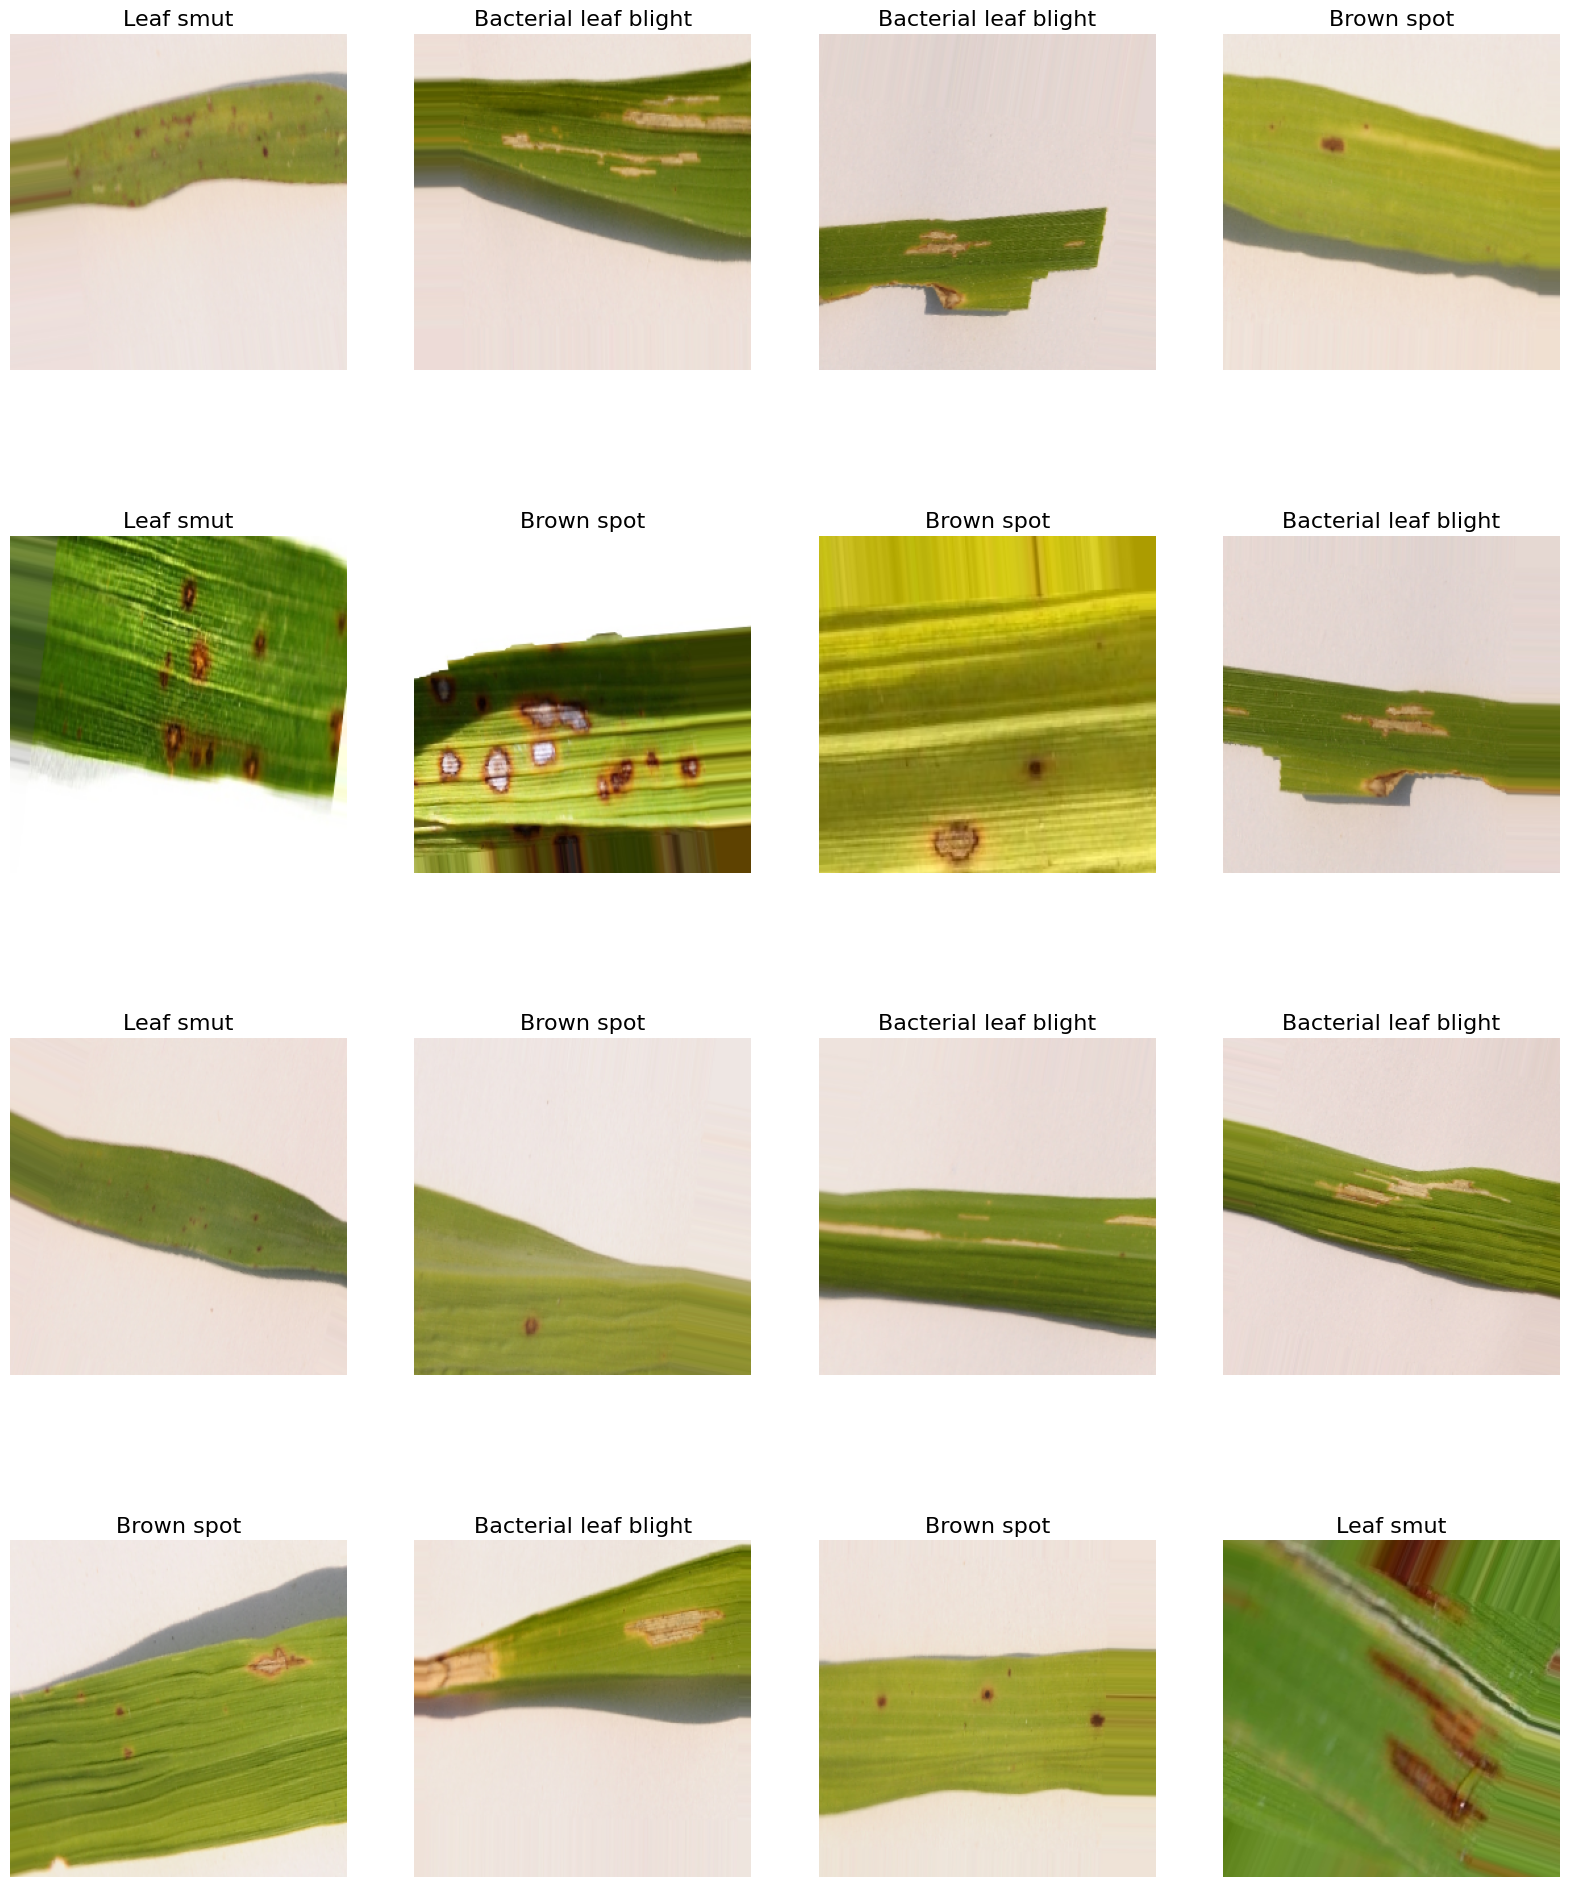

In [110]:
# Calling the plots() function:
imgs, labels = next(train_generator)
plots(imgs, title = labels)

In [111]:
# CNN Modelling:
from keras import models, layers

# Build the model with Sequential Model Structure:
model = models.Sequential()

# Adding Convolutional Blocks:
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu',input_shape=(256,256,3)))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(filters=64,kernel_size=(3,3),activation= 'relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(filters=128,kernel_size=(3,3),activation= 'relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(filters=256,kernel_size=(3,3),activation= 'relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))


# Adding Droput to avoid Overfitting:
model.add(layers.Dropout(rate=0.5))

# Adding Flatten to pass the input data as a vector:
model.add(layers.Flatten())

# Final Output Layer:
model.add(layers.Dense(3, activation ='softmax'))


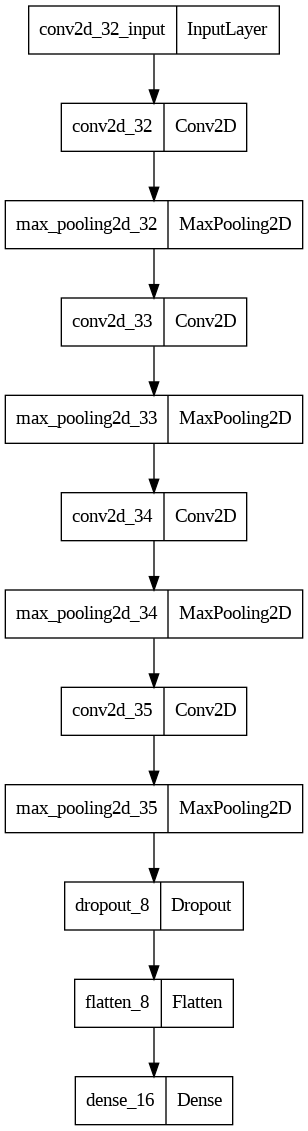

In [112]:
# Plotting the Model Flow:
from keras import utils

keras.utils.plot_model(model)

In [113]:
# Checking Model Summary:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 30, 30, 128)      

In [114]:
# Compiling the Model:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [115]:
# Fitting the Data Generator to the Model:

history = model.fit_generator(train_generator,
                              epochs=35,
                              validation_data = val_generator)


Epoch 1/35
8/8 [==============================] - 26s 3s/step - loss: 1.1316 - accuracy: 0.3478 - val_loss: 1.0845 - val_accuracy: 0.3684
Epoch 2/35
8/8 [==============================] - 25s 3s/step - loss: 1.0814 - accuracy: 0.3391 - val_loss: 1.0181 - val_accuracy: 0.3158
Epoch 3/35
8/8 [==============================] - 26s 3s/step - loss: 1.0521 - accuracy: 0.4261 - val_loss: 0.9285 - val_accuracy: 0.5263
Epoch 4/35
8/8 [==============================] - 22s 3s/step - loss: 0.9889 - accuracy: 0.5043 - val_loss: 0.8324 - val_accuracy: 0.6842
Epoch 5/35
8/8 [==============================] - 24s 3s/step - loss: 0.9634 - accuracy: 0.5391 - val_loss: 0.9118 - val_accuracy: 0.4211
Epoch 6/35
8/8 [==============================] - 23s 3s/step - loss: 0.9873 - accuracy: 0.5391 - val_loss: 0.8037 - val_accuracy: 0.5263
Epoch 7/35
8/8 [==============================] - 23s 3s/step - loss: 0.8209 - accuracy: 0.6435 - val_loss: 0.7620 - val_accuracy: 0.6842
Epoch 8/35
8/8 [==================

In [116]:
# Saving the Model:
model.save("model.h5")

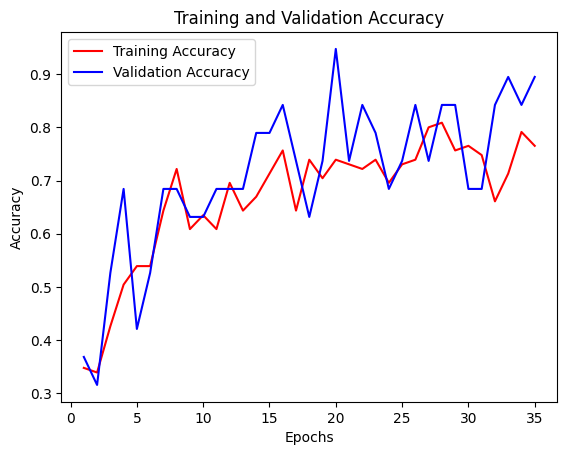

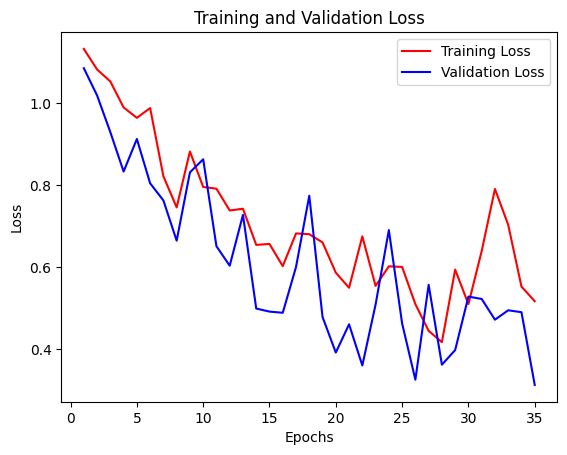

In [117]:
# Creating variables for the Plots:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

# Plotting the Training Accuracy and Validation Accuracy:
plt.plot(epochs, accuracy, "r", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.figure()

# Plotting the Traning Loss and Validation Loss:
plt.plot(epochs, loss, "r", label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [118]:
# Created Model Summary:

model = keras.models.load_model("model.h5")
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 30, 30, 128)      

**Model Testing on Test Data Images**

In [119]:
# Instantiating ImageDataGenerator class with Rescale parameter:
test_datagen = ImageDataGenerator(rescale=(1./255))

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(256,256),
                                                  batch_size=16,
                                                  color_mode='rgb',
                                                  class_mode='categorical')

Found 26 images belonging to 3 classes.


In [120]:
# Model Evaluation on Test Images:
model.evaluate(test_generator)

2/2 [==============================] - 2s 428ms/step - loss: 0.4421 - accuracy: 0.8077


[0.4421003460884094, 0.807692289352417]

- Test Accuracy: **80.77**
- Test Loss: **0.44**